In [1]:
import os
import difflib
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
csv_file_path2 = '/home/nogaschw/Codeworkout/course2.csv'
csv_file_path3 = '/home/nogaschw/Codeworkout/course3.csv'
csv_file_path4 = '/home/nogaschw/Codeworkout/course4.csv'

df2 = pd.read_csv(csv_file_path2, sep='\t', encoding='latin1')
df3 = pd.read_csv(csv_file_path3, sep='\t', encoding='latin1')
df4 = pd.read_csv(csv_file_path4, sep='\t', encoding='latin1')

In [3]:
def arrange_data(df):
    df = df.sort_values('timestamp', ascending=True)
    df = df.groupby(['student_id', 'problem_id']).apply(lambda x: pd.Series({
        'ServerTimestamp': x['timestamp'].tolist(),
        'score': x['score'].tolist(),
        'source_code': x['source_code'].tolist()
    })).reset_index()
    df['num_snapshots'] = df['source_code'].apply(lambda x: len(x))
    df['time_to_solve'] = df['ServerTimestamp'].apply(lambda x: (pd.to_datetime(x[-1]) - pd.to_datetime(x[0])).seconds)
    df['time_between_snapshots'] = df['ServerTimestamp'].apply(lambda x: [(pd.to_datetime(x[i]) - pd.to_datetime(x[i-1])).seconds for i in range(1, len(x))])
    df['success'] = df['score'].apply(lambda x: 1 if x.__contains__(100) else 0)
    return df

In [4]:
df2 = arrange_data(df2)
df3 = arrange_data(df3)
df4 = arrange_data(df4)
df = pd.concat([df2, df3, df4])

#### Quetion per Student

(array([ 19.,  16.,  30., 129., 592., 611., 147.,  16.,   1.,   1.]),
 array([  1. ,  23.5,  46. ,  68.5,  91. , 113.5, 136. , 158.5, 181. ,
        203.5, 226. ]),
 <BarContainer object of 10 artists>)

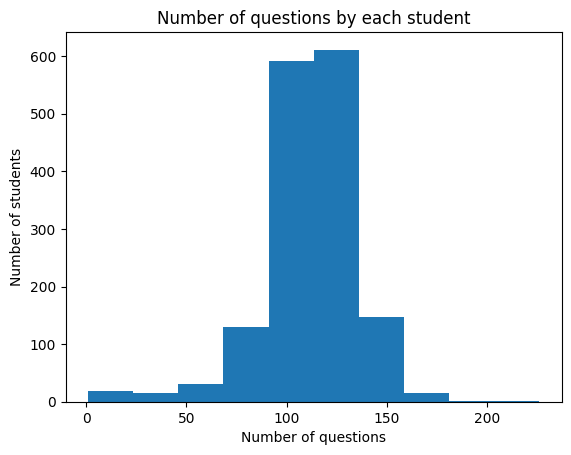

In [5]:
x = sorted(df.groupby('student_id')['problem_id'].nunique())
plt.title('Number of questions by each student')
plt.xlabel('Number of questions')
plt.ylabel('Number of students')
plt.hist(x)

#### Successful

In [6]:
df['Max.Score'] = df['score'].apply(lambda x: max(x))
successfull = df[df['Max.Score'] == 100]
not_successfull = df[df['Max.Score'] < 100]
len(successfull), len(not_successfull)

(156440, 18536)

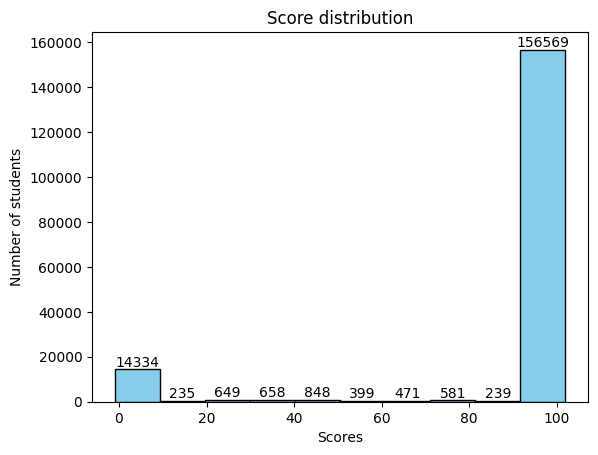

In [7]:
x = df['Max.Score']
plt.title('Score distribution')
plt.xlabel('Scores')
plt.ylabel('Number of students')
n, bins, patches = plt.hist(x, color='skyblue', edgecolor='black')
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, patches[i].get_height(), int(patches[i].get_height()), ha='center', va='bottom')

plt.show()

#### Snapshots per Student

In [8]:
snapshot_stat = df.groupby(['problem_id']).apply(lambda x: pd.Series({
    'number_of_students': x['student_id'].nunique(), 
    'min_snapshots': x['num_snapshots'].min(),
    'max_snapshots': x['num_snapshots'].max(),
    'mean_snapshots': x['num_snapshots'].mean(),
    'median_snapshots': x['num_snapshots'].median(),
})).reset_index()

snapshot_stat

,problem_id,number_of_students,min_snapshots,max_snapshots,mean_snapshots,median_snapshots
0,AirStrike,1.0,1.0,1.0,1.000000,1.0
1,Airstrike,566.0,1.0,653.0,130.630742,109.0
2,CAESAR,1.0,1.0,1.0,1.000000,1.0
3,CS110_Ingenuity_Simulator_Spiral_1,418.0,1.0,901.0,157.693780,137.5
4,CS110_Ingenuity_Simulator_Spiral_2,295.0,1.0,378.0,61.569492,49.0
...,...,...,...,...,...,...
456,lsn9_skill2,398.0,1.0,48.0,2.919598,2.0
457,lsn9_skill3,397.0,1.0,23.0,2.687657,1.0
458,lsn9_triangle,409.0,1.0,46.0,3.437653,2.0
459,pex2,130.0,1.0,121.0,13.623077,6.0


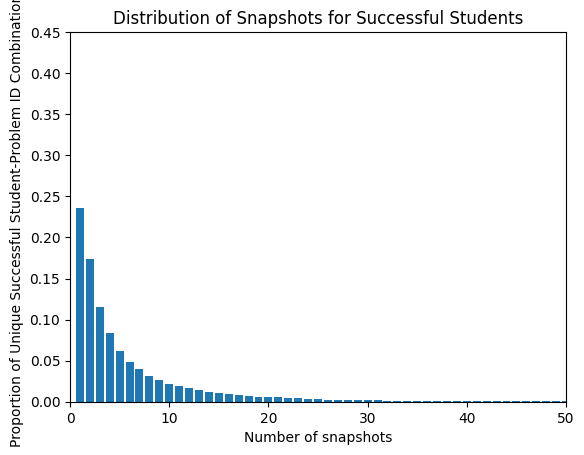

In [9]:
plt.title('Distribution of Snapshots for Successful Students')
plt.xlabel('Number of snapshots')
plt.ylabel('Proportion of Unique Successful Student-Problem ID Combinations')
plt.xlim(0, 50)
plt.ylim(0, 0.45)

success = df[df['success'] == 1]['num_snapshots']
success = success.value_counts(normalize=True).sort_index()
plt.bar(success.index, success.values)
plt.show()

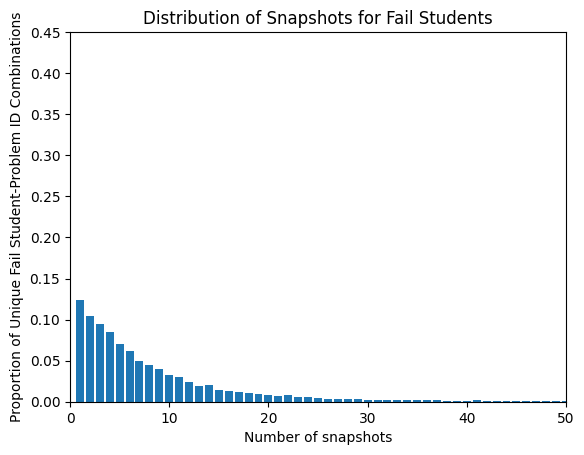

In [10]:
plt.title('Distribution of Snapshots for Fail Students')
plt.xlabel('Number of snapshots')
plt.ylabel('Proportion of Unique Fail Student-Problem ID Combinations')
plt.xlim(0, 50)
plt.ylim(0, 0.45)

fail = df[df['success'] == 0]['num_snapshots']
fail = fail.value_counts(normalize=True).sort_index()
plt.bar(fail.index, fail.values)
plt.show()

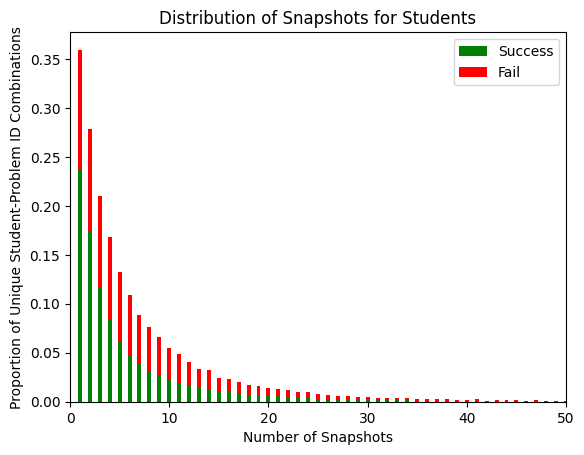

In [11]:
combined_index = success.index.union(fail.index)
success = success.reindex(combined_index, fill_value=0)
fail = fail.reindex(combined_index, fill_value=0)

plt.xlim(0, 50)

bar_width = 0.4
plt.bar(combined_index, success.values, width=bar_width, color='g', label='Success')
plt.bar(combined_index, fail.values, bottom=success.values, width=bar_width, color='r', label='Fail')

plt.title('Distribution of Snapshots for Students')
plt.xlabel('Number of Snapshots')
plt.ylabel('Proportion of Unique Student-Problem ID Combinations')
plt.legend()
plt.show()

#### Time

In [12]:
df_without_one_snapshot = df[df['num_snapshots'] > 1]
time_stat = df_without_one_snapshot.groupby(['problem_id']).apply(lambda x: pd.Series({
    'number_of_students': x['student_id'].nunique(), 
    'min_time_to_solve': x['time_to_solve'].min()/60,
    'max_time_to_solve': x['time_to_solve'].max()/60,
    'mean_time_to_solve': x['time_to_solve'].mean()/60,
    'median_time_to_solve': x['time_to_solve'].median()/60,
    'mean_time_between_snapshots': x['time_between_snapshots'].apply(lambda y: sum(y) / len(y)).mean()/60,
    'median_time_between_snapshots': x['time_between_snapshots'].apply(lambda y: sum(y) / len(y)).median()/60,
})).reset_index()

time_stat # in minutes

,problem_id,number_of_students,min_time_to_solve,max_time_to_solve,mean_time_to_solve,median_time_to_solve,mean_time_between_snapshots,median_time_between_snapshots
0,Airstrike,555.0,0.100000,1437.466667,577.142132,474.200000,51.842660,40.886532
1,CS110_Ingenuity_Simulator_Spiral_1,415.0,0.383333,1436.983333,657.802771,613.183333,40.954196,31.392341
2,CS110_Ingenuity_Simulator_Spiral_2,290.0,1.016667,1438.850000,609.645287,544.508333,73.620419,49.148537
3,CS110_Ingenuity_Simulator_Spiral_3,222.0,0.283333,1436.800000,470.473273,358.533333,76.138036,32.516343
4,CS110_Ingenuity_Simulator_spiral_2,1.0,1367.100000,1367.100000,1367.100000,1367.100000,51.038182,51.038182
...,...,...,...,...,...,...,...,...
449,lsn9_skill2,222.0,0.083333,1363.516667,110.408033,2.108333,62.200340,0.969595
450,lsn9_skill3,196.0,0.033333,1387.500000,190.285459,3.466667,106.369851,1.319167
451,lsn9_triangle,224.0,0.050000,1434.800000,286.062500,6.291667,113.726782,2.079167
452,pex2,112.0,0.100000,1437.150000,328.967262,87.958333,83.722349,22.166667


In [13]:
df_at_least_10 = df_without_one_snapshot[df_without_one_snapshot['num_snapshots'] >= 10]

time_vs_snapshots = {}
for index, row in df_at_least_10.iterrows():
    if row['problem_id'] not in time_vs_snapshots:
        time_vs_snapshots[row['problem_id']] = {}
    for i in range (1, row['num_snapshots']):
        if i not in time_vs_snapshots[row['problem_id']]:
            time_vs_snapshots[row['problem_id']][i] = []
        time_vs_snapshots[row['problem_id']][i].append(row['time_between_snapshots'][i - 1])

time_vs_snapshots
avg_snapshots_vs_time = {}
len_snapshots_vs_time = {}
for key, value in time_vs_snapshots.items():
    avg_snapshots_vs_time[key] = {}
    len_snapshots_vs_time[key] = {}
    for k, v in value.items():
        avg_snapshots_vs_time[key][k] = sum(v) / len(v)
        len_snapshots_vs_time[key][k] = len(v)

data = []

# Iterate over items in avg_snapshots_vs_score
for key, value in avg_snapshots_vs_time.items():
    for k, v in value.items():
        # Append a dictionary to the list
        data.append({'problem_id': key, 'Snapshot': k, 'Time between Snapshots': v, 'Number of Students': len_snapshots_vs_time[key][k]})

len_snapshots_vs_time = pd.DataFrame(data)


In [14]:
len_snapshots_vs_time = len_snapshots_vs_time[len_snapshots_vs_time['Number of Students'] > 10]
len_snapshots_vs_time['Time between Snapshots'] = len_snapshots_vs_time['Time between Snapshots'].apply(lambda x: x / 60)

Text(0.5, 1.0, 'Time between Snapshots vs Snapshots')

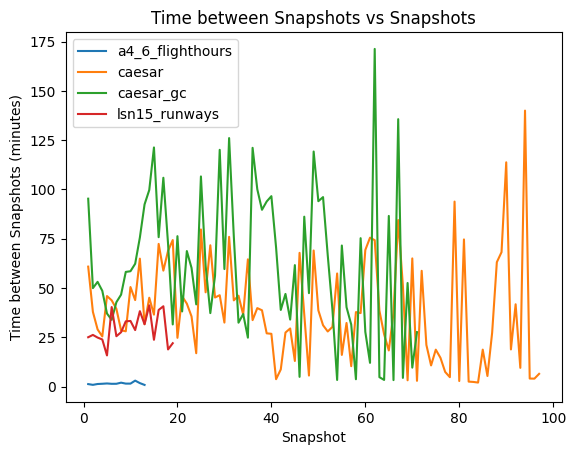

In [15]:
save_data = {}
fig, ax = plt.subplots()
for key, grp in len_snapshots_vs_time.head(200).groupby('problem_id'):
    save_data[key] = grp
    ax.plot(grp['Snapshot'], grp['Time between Snapshots'], label=key)
ax.legend()
plt.xlabel('Snapshot')
plt.ylabel('Time between Snapshots (minutes)')
plt.title('Time between Snapshots vs Snapshots')

Checking why consecutive snapshots are done with almost zero delay between them

In [16]:
for key, value in save_data.items():
    print(f"Minimum time to solve {key} is {value['Time between Snapshots'].min().round(2)}")

Minimum time to solve a4_6_flighthours is 0.85
Minimum time to solve caesar is 2.04
Minimum time to solve caesar_gc is 3.29
Minimum time to solve lsn15_runways is 15.8


Time between snapshots for cafe218b-2960-4a58-9c48-8bb46af99750 is [27, 1630, 28, 5, 13, 23, 44, 20, 39] (seconds)
Time between snapshots for ba93f78f-ca91-497e-9049-21f9aa9c2f55 is [20, 133, 38, 89, 4, 1751, 137, 54, 22] (seconds)
Time between snapshots for 5d544c1c-a6b2-449f-a90f-df44b2e264c7 is [138, 7, 77, 51, 28, 615, 96, 51, 42] (seconds)
Time between snapshots for 6e17ee7b-b49b-4d95-aadd-959a8344dc02 is [102, 95, 33, 103, 43, 37, 170, 58, 1611] (seconds)


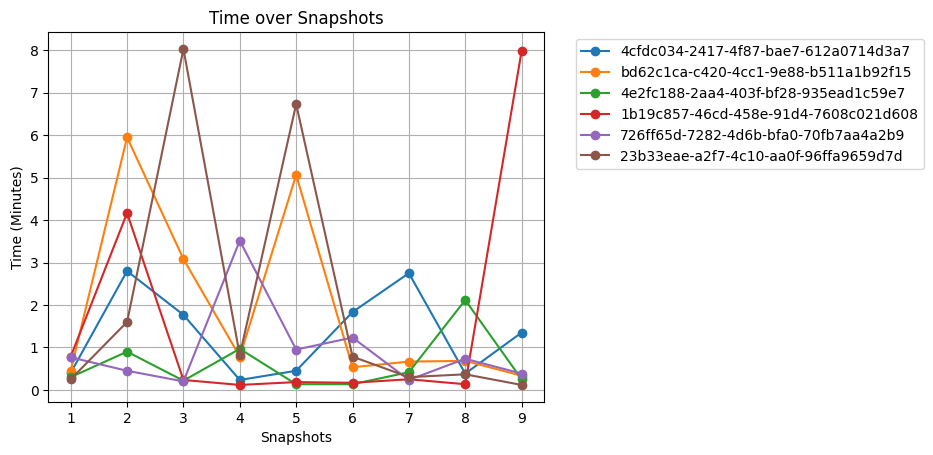

In [17]:
save_data = {}
random_10_fail = not_successfull[not_successfull["num_snapshots"] == 10].sample(10)
for index, row in random_10_fail.iterrows():
    if max(row['time_between_snapshots']) / 60 > 10:
        print(f"Time between snapshots for {row['student_id']} is {row['time_between_snapshots']} (seconds)")
        continue
    save_data[index] = row
    snapshots = list(range(1, row['num_snapshots']))
    t = [x/60 for x in row['time_between_snapshots']]
    plt.plot(snapshots, t, marker='o', label=row['student_id'])

plt.xlabel('Snapshots')
plt.ylabel('Time (Minutes)')
plt.title('Time over Snapshots')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

#### Changes in Lines between Snapshots

In [20]:
def get_diffs(snapshots):
    diffs = []
    for i in range(1, len(snapshots)):
        diff = difflib.unified_diff(snapshots[i-1].splitlines(), snapshots[i].splitlines())
        diffs.append(list(diff))
    return diffs

df['diffs'] = df['source_code'].apply(lambda x: get_diffs(x))
df_lines = df[df['source_code'].apply(lambda x: len(x) > 1) & df['diffs'].apply(lambda x: len(x) > 0 and len(x[0]) > 0)]

In [27]:
def get_deleted_inserted_lines(diffs):
    deleted = []
    inserted = []
    for diff in diffs:
        del_lines = 0
        ins_lines = 0
        for line in diff:
            if line.startswith('-'):
                del_lines += 1
            elif line.startswith('+'):
                ins_lines += 1
        deleted.append(del_lines)
        inserted.append(ins_lines)
    return deleted, inserted

df_lines['deleted'], df_lines['inserted'] = zip(*df_lines['diffs'].apply(lambda x: get_deleted_inserted_lines(x)))

/tmp/ipykernel_10945/97789572.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lines['deleted'], df_lines['inserted'] = zip(*df_lines['diffs'].apply(lambda x: get_deleted_inserted_lines(x)))
/tmp/ipykernel_10945/97789572.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lines['deleted'], df_lines['inserted'] = zip(*df_lines['diffs'].apply(lambda x: get_deleted_inserted_lines(x)))


In [28]:
success_with_snapshots = df_lines[df_lines['success'] == 1]
number_of_snapshots_success = success_with_snapshots['num_snapshots'].sum()

fail_with_snapshots = df_lines[df_lines['success'] == 0]
number_of_snapshots_fail = fail_with_snapshots['num_snapshots'].sum()
print(f"Number of snapshots for successful students: {number_of_snapshots_success}")
print(f"Number of snapshots for fail students: {number_of_snapshots_fail}")

Number of snapshots for successful students: 761699
Number of snapshots for fail students: 245179


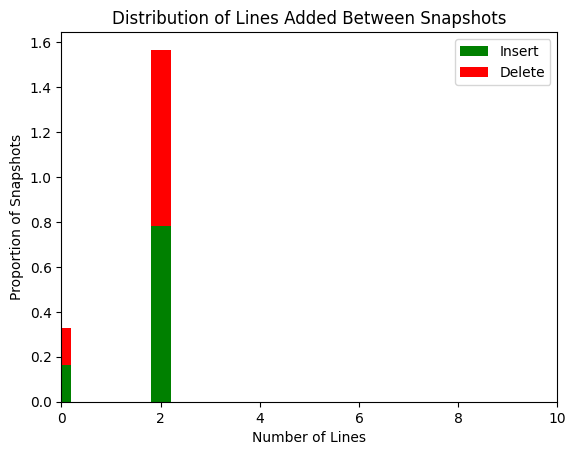

In [31]:
inserted = fail_with_snapshots['inserted'].apply(pd.Series).stack().value_counts().sort_index() / number_of_snapshots_fail
deleted = fail_with_snapshots['deleted'].apply(pd.Series).stack().value_counts().sort_index() / number_of_snapshots_fail

combined_index = inserted.index.union(deleted.index)
inserted = inserted.reindex(combined_index, fill_value=0)
deleted = deleted.reindex(combined_index, fill_value=0)

bar_width = 0.4

plt.bar(combined_index, inserted.values, width=bar_width, color='g', label='Insert')
plt.bar(combined_index, deleted.values, bottom=inserted.values, width=bar_width, color='r', label='Delete')

plt.xlim(0, 10)
plt.title('Distribution of Lines Added Between Snapshots')
plt.xlabel('Number of Lines')
plt.ylabel('Proportion of Snapshots')
plt.legend()
plt.show()

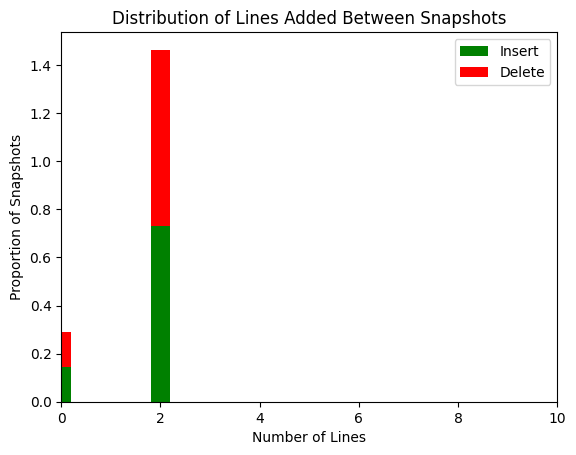

In [33]:
inserted = success_with_snapshots['inserted'].apply(pd.Series).stack().value_counts().sort_index() / number_of_snapshots_success
deleted = success_with_snapshots['deleted'].apply(pd.Series).stack().value_counts().sort_index() / number_of_snapshots_success

combined_index = inserted.index.union(deleted.index)
inserted = inserted.reindex(combined_index, fill_value=0)
deleted = deleted.reindex(combined_index, fill_value=0)


plt.bar(combined_index, inserted.values, width=bar_width, color='g', label='Insert')
plt.bar(combined_index, deleted.values, bottom=inserted.values, width=bar_width, color='r', label='Delete')

plt.xlim(0, 10)
plt.title('Distribution of Lines Added Between Snapshots')
plt.xlabel('Number of Lines')
plt.ylabel('Proportion of Snapshots')
plt.legend()
plt.show()

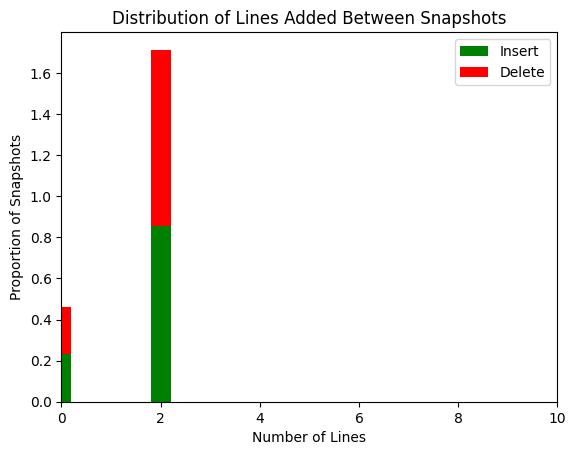

In [36]:
inserted = df['inserted'].apply(pd.Series).stack().value_counts().sort_index() / (number_of_snapshots_success + number_of_snapshots_fail)
deleted = df['deleted'].apply(pd.Series).stack().value_counts().sort_index() / (number_of_snapshots_success + number_of_snapshots_fail)

combined_index = inserted.index.union(deleted.index)
inserted = inserted.reindex(combined_index, fill_value=0)
deleted = deleted.reindex(combined_index, fill_value=0)

bar_width = 0.4

plt.bar(combined_index, inserted.values, width=bar_width, color='g', label='Insert')
plt.bar(combined_index, deleted.values, bottom=inserted.values, width=bar_width, color='r', label='Delete')

plt.xlim(0, 10)
plt.title('Distribution of Lines Added Between Snapshots')
plt.xlabel('Number of Lines')
plt.ylabel('Proportion of Snapshots')
plt.legend()
plt.show()

I decided to define the number of changed lines as the maximum between the inserted lines and the deleted lines.

In [42]:
# Look on specific quetions
question = 'a1_1_dorms'
specific_quetion_success = df[(df['problem_id'] == question) & (df['num_snapshots'] >= 8) & (df['num_snapshots'] <= 10) & (df['success'] == 1)]
specific_quetion_success = specific_quetion_success.head(8)

specific_quetion_fail = df[(df['problem_id'] == question) & (df['num_snapshots'] >= 8) & (df['num_snapshots'] <= 10) & (df['success'] == 0)]
specific_quetion_fail = specific_quetion_fail.head(8)

In [44]:
def plot_snapshot(specific_quetion):
    for index, row in specific_quetion.iterrows():
        snapshots = list(range(1, row['num_snapshots']))
        plt.plot(snapshots, max(row['deleted'], row['inserted']), marker='o', label=row['student_id'])

    plt.xlabel('Snapshots')
    plt.ylabel('Changed Lines')
    plt.title('Changed Lines over Snapshots')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()


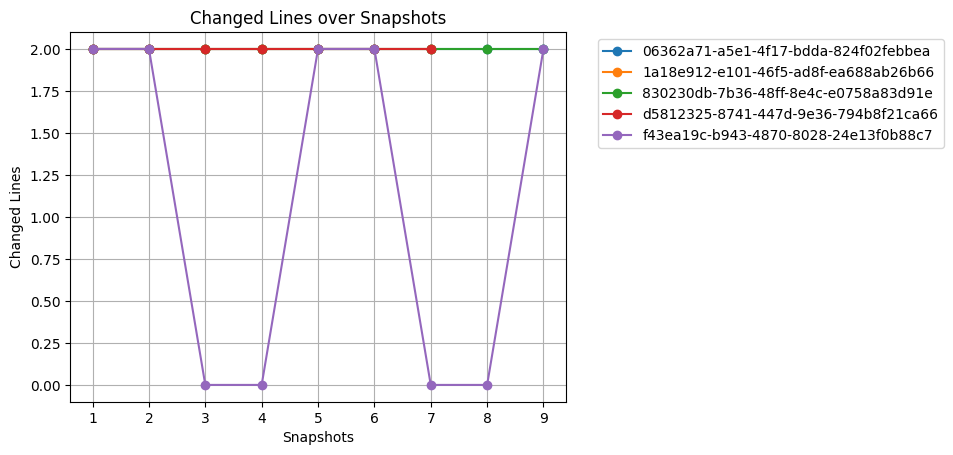

In [45]:
plot_snapshot(specific_quetion_success)

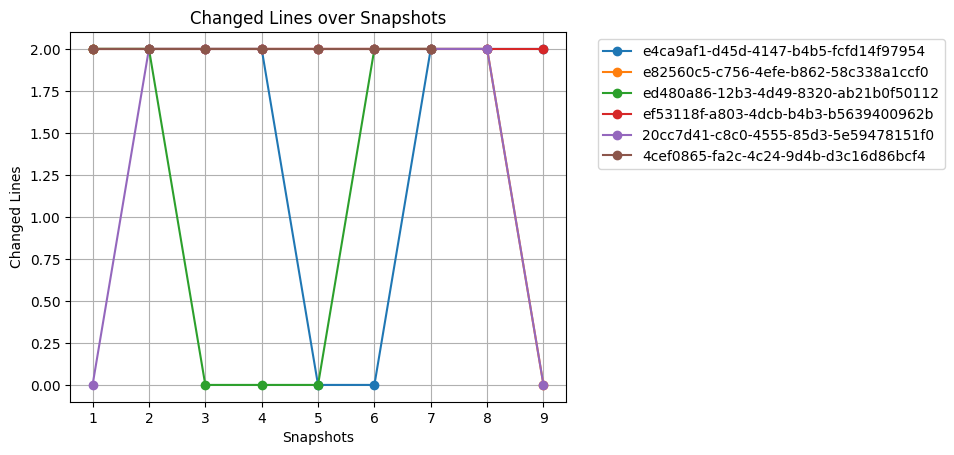

In [46]:
plot_snapshot(specific_quetion_fail)

#### Explore Students Who not Finish The Question

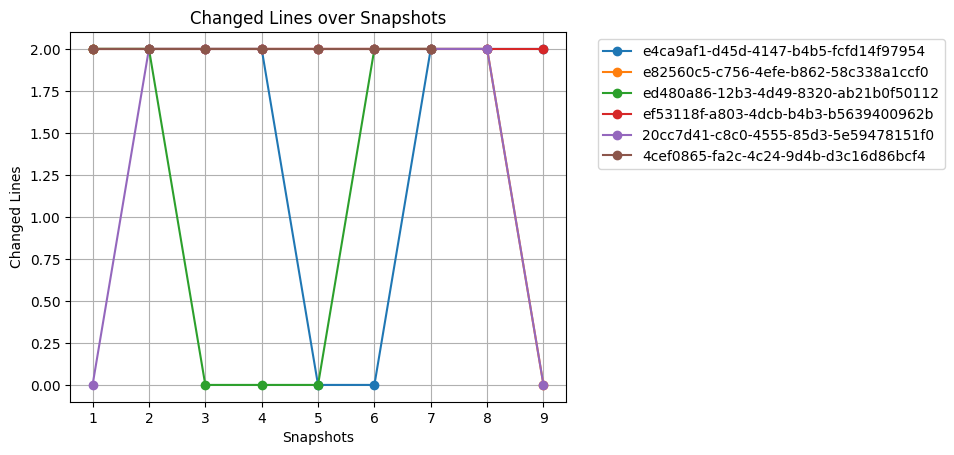

In [47]:
plot_snapshot(specific_quetion_fail)

In [49]:
df_fail = df[df['success'] == 0]

snapshots_vs_score = {}
for index, row in df_fail.iterrows():
    if row['problem_id'] not in snapshots_vs_score:
        snapshots_vs_score[row['problem_id']] = {}
    for i in range (1, row['num_snapshots'] + 1):
        if i not in snapshots_vs_score[row['problem_id']]:
            snapshots_vs_score[row['problem_id']][i] = []
        snapshots_vs_score[row['problem_id']][i].append(row['score'][i - 1])

avg_snapshots_vs_score = {}
len_snapshots_vs_score = {}
for key, value in snapshots_vs_score.items():
    avg_snapshots_vs_score[key] = {}
    len_snapshots_vs_score[key] = {}
    for k, v in value.items():
        avg_snapshots_vs_score[key][k] = sum(v) / len(v)
        len_snapshots_vs_score[key][k] = len(v)

data = []

# Iterate over items in avg_snapshots_vs_score
for key, value in avg_snapshots_vs_score.items():
    for k, v in value.items():
        # Append a dictionary to the list
        data.append({'problem_id': key, 'Snapshot': k, 'Average Score': v, 'Number of Students': len_snapshots_vs_score[key][k]})

df_snapshots_vs_score = pd.DataFrame(data)
df_snapshots_vs_score

,problem_id,Snapshot,Average Score,Number of Students
0,lsn21_randomcircles,1,-1.0,10
1,lsn21_randomcircles,2,-1.0,9
2,lsn21_randomcircles,3,-1.0,7
3,lsn21_randomcircles,4,-1.0,5
4,lsn21_randomcircles,5,-1.0,2
...,...,...,...,...
15081,CS110_Ingenuity_Simulator_spiral_2,56,-1.0,1
15082,CS110_Ingenuity_Simulator_spiral_3,1,-1.0,1
15083,CS110_Ingenuity_Simulator_spiral_3,2,-1.0,1
15084,CS110_Ingenuity_Simulator_spiral_3,3,-1.0,1


In [50]:
# arrange by limit to 10 snapshots and at least 5 students
df_snapshots_vs_score_10 = df_snapshots_vs_score[(df_snapshots_vs_score['Snapshot'] <= 10) & (df_snapshots_vs_score['Number of Students'] >= 5)]

In [51]:
df_all = df_snapshots_vs_score.groupby('Snapshot').apply(lambda x: pd.Series({
    'mean_score': x['Average Score'].mean(),
    'number_of_students': x['Number of Students'].sum(),
})).reset_index()

The mean score is problemtic (The number of student is decrease)

<Axes: title={'center': 'Score of Student not Finish the Question by Snapshots'}, xlabel='Snapshots', ylabel='Mean Score'>

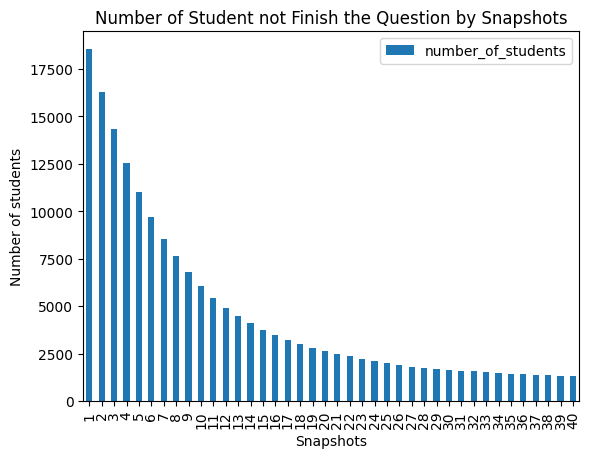

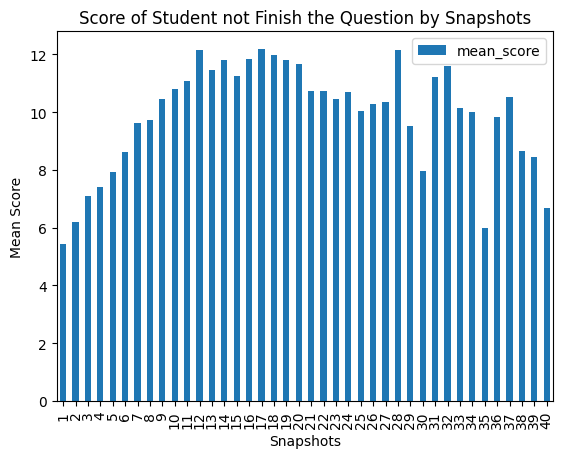

In [52]:
df_snapshots_vs_score_40 = df_all.head(40)
df_snapshots_vs_score_40.plot(x='Snapshot', y='number_of_students', kind='bar', xlabel='Snapshots', ylabel='Number of students', title='Number of Student not Finish the Question by Snapshots')
df_snapshots_vs_score_40.plot(x='Snapshot', y='mean_score', kind='bar', xlabel='Snapshots', ylabel='Mean Score', title='Score of Student not Finish the Question by Snapshots')


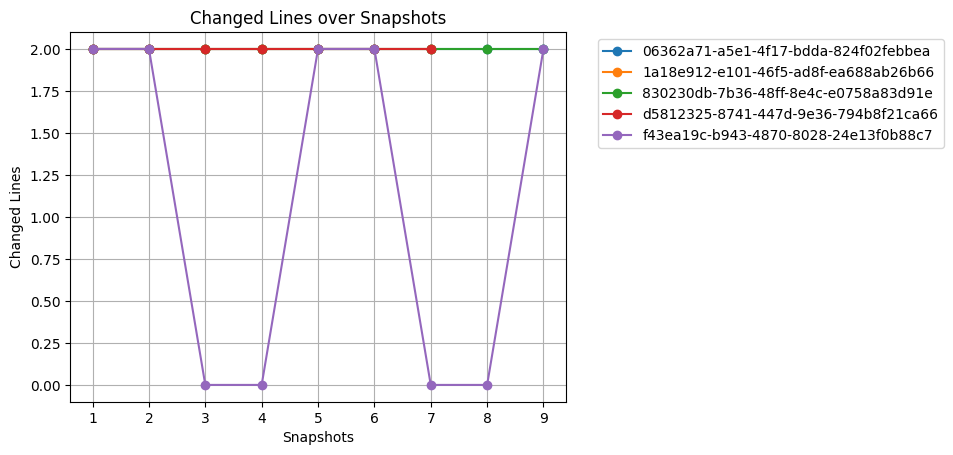

In [54]:
plot_snapshot(specific_quetion_success)

# Define Struggling Student

In [55]:
all_courses_without_one_snapshot = df[df['num_snapshots'] > 1]
df_without_break = all_courses_without_one_snapshot[all_courses_without_one_snapshot['time_between_snapshots'].apply(lambda x: max(x) <= 600)]
df_without_break['Max.Score'] = df_without_break['score'].apply(lambda x: max(x))

df_1_score = df_without_break[df_without_break['success'] == 0]

len_struggling_by_score = len(df_1_score) 
len_data =len(df_without_break)

(len_struggling_by_score / len_data) * 100

/tmp/ipykernel_10945/278698939.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_break['Max.Score'] = df_without_break['score'].apply(lambda x: max(x))


10.519905042445032

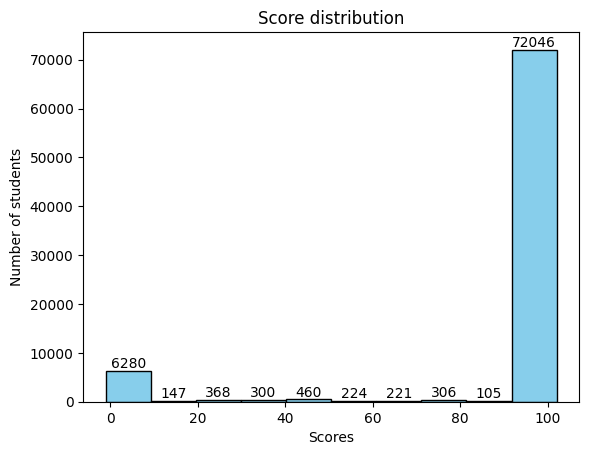

In [56]:
x = df_without_break['Max.Score']
plt.title('Score distribution')
plt.xlabel('Scores')
plt.ylabel('Number of students')
n, bins, patches = plt.hist(x, color='skyblue', edgecolor='black')
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, patches[i].get_height(), int(patches[i].get_height()), ha='center', va='bottom')

plt.show()

In [57]:
# measure avg without student who take a break (more than 10 minutes between snapshots)
df_without_break_grouped = df_without_break.groupby(['problem_id'])

# Calculate average time to solve for each group
avg_time_to_solve = df_without_break_grouped['time_to_solve'].mean()

# Calculate average attempts for each group
avg_attempts = df_without_break_grouped['num_snapshots'].mean()

variance_time_to_solve = df_without_break_grouped['time_to_solve'].var()

std_dev_time_to_solve = df_without_break_grouped['time_to_solve'].std()

variance_num_snapshots = df_without_break_grouped['num_snapshots'].var()

std_dev_num_snapshots = df_without_break_grouped['num_snapshots'].std()


# Combine the results into a DataFrame
result_df = pd.DataFrame({
    'avg_time_to_solve': avg_time_to_solve,
    'avg_attempts': avg_attempts,
    'variance_time_to_solve': variance_time_to_solve,
    'std_dev_time_to_solve': std_dev_time_to_solve,
    'variance_num_snapshots': variance_num_snapshots,
    'std_dev_num_snapshots': std_dev_num_snapshots
}).reset_index()

result_df


,problem_id,avg_time_to_solve,avg_attempts,variance_time_to_solve,std_dev_time_to_solve,variance_num_snapshots,std_dev_num_snapshots
0,Airstrike,802.357143,8.642857,649586.401099,805.969231,61.324176,7.830975
1,CS110_Ingenuity_Simulator_Spiral_1,268.250000,3.250000,37292.916667,193.113740,0.916667,0.957427
2,CS110_Ingenuity_Simulator_Spiral_2,801.000000,10.666667,470149.000000,685.674121,85.500000,9.246621
3,CS110_Ingenuity_Simulator_Spiral_3,480.162162,6.108108,403634.361862,635.322250,43.932432,6.628155
4,CS110_Ingenuity_Simulator_spiral_3,743.000000,4.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
444,lsn9_skill2,189.959538,3.936416,85699.387888,292.744578,18.780817,4.333684
445,lsn9_skill3,188.395683,3.690647,66358.617662,257.601665,9.635492,3.104109
446,lsn9_triangle,149.090164,3.663934,41176.132299,202.919029,9.646457,3.105875
447,pex2,335.000000,4.269231,194303.520000,440.798730,21.324615,4.617858


In [58]:
print("avg time to solve: ", result_df['avg_time_to_solve'].mean())
print("std dev time to solve:",result_df['std_dev_time_to_solve'].mean())

avg time to solve:  308.42343228185996
std dev time to solve: 338.15353579884544


In [59]:
columns = ['student_id', 'problem_id', 'num_snapshots', 'time_to_solve', 'time_between_snapshots', 'Max.Score', 'source_code']

data = [['student_id', 'problem_id', 'num_snapshots', 'time_to_solve', 'time_between_snapshots', 'Max.Score', 'source_code']]

for index, row in df_without_break.iterrows():
    problem = row['problem_id']
    avg = result_df[result_df['problem_id'] == problem]['avg_time_to_solve'].values[0]
    std = result_df[result_df['problem_id'] == problem]['std_dev_time_to_solve'].values[0]
    if row['time_to_solve'] > avg + 1 * std:
        data.append([row['student_id'], row['problem_id'], row['num_snapshots'], row['time_to_solve'], row['time_between_snapshots'], row['Max.Score'], row['source_code']])

time_std = pd.DataFrame(data[1:], columns=columns)

In [60]:
len(time_std) / len_data * 100

12.655207129274022

In [61]:
df_1_score['time_between_snapshots'] = df_1_score['time_between_snapshots'].apply(tuple)
time_std['time_between_snapshots'] = time_std['time_between_snapshots'].apply(tuple)

time_std['source_code'] = time_std['source_code'].apply(tuple)
df_1_score['source_code'] = df_1_score['source_code'].apply(tuple)


df_all = pd.merge(df_1_score, time_std, how='outer', indicator=True)
len(df_all) / len_data * 100

/tmp/ipykernel_10945/3824636683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1_score['time_between_snapshots'] = df_1_score['time_between_snapshots'].apply(tuple)
/tmp/ipykernel_10945/3824636683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1_score['source_code'] = df_1_score['source_code'].apply(tuple)


21.152913978895562